# Spectrogram Analysis of Vinyl Recordings
In Audacity, we noticed that background noise was mostly in the 0-0.1 kHz band. Here we attempt to isolate quiet places on the record (by high ratio of background to foreground noise) to characterize the amount of crackle on the record.

#### First we import some libraries.

In [1]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 8]

import numpy as np
np.set_printoptions(suppress=True)

#### The file to analyze is selected, loaded, and collapsed into a single mono track. We assume the input is a 16-bit pulse code modulated `wav` file.

In [2]:
from scipy.io import wavfile

filename = 'media/A_1.wav'
sample_rate, signal = wavfile.read(filename)

print(f"The recording is sampled at {sample_rate}Hz with a duration of {signal.shape[0]/sample_rate/60 : 0.2f} minutes.")
print(f"The maximum sample amplitude is {max(signal.max(), -1-signal.min())}. It should be 32767 if this is a 16 bit wav file.")

signal = signal.sum(axis=1)/2

The recording is sampled at 44100Hz with a duration of  18.07 minutes.
The maximum sample amplitude is 32767. It should be 32767 if this is a 16 bit wav file.


#### We then take the spectrogram of the audio signal.
We are using the [scipy implementation.](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.spectrogram.html) 

<div class="image12">
    <div style="float:left;margin-right:5px;">
        <img src="images/spec.png" height="500" width="650"  />
    </div>
    <div style="float:left;margin-right:5px;">
        <img class="right-img" src="images/default_settings.png" height="500" width="300" />
    </div>
</div>

[1] [2]

Parameters for the spectrogram were borrowed from the default parameters from Audacity, as those are tuned for processing music and speech. The default parameters for scipy are more general, and work over a broader range of abstract signals but are too sensitive here.

In [3]:
from scipy.signal import spectrogram

freq_ax, time_ax, spec = spectrogram(signal, sample_rate, window="hann", nperseg=8192, noverlap=8192*0.25, scaling="spectrum")
dt = time_ax[1]-time_ax[0]

#### We will now attempt to identify areas of silence in the song.
The algorithm we use will rely on the prevelance of 100 Hz noise in the recordings. This noise was observed in many different vinyl recordings by inspection using a tool called [Audacity](https://www.audacityteam.org/). 

![image.png](images/audacity.png)

It can be seen in the bright yellow strip consistently across the record along the bottom of the spectrogram. This means that the signal always contains those frequencies, regardless of what is playing. The bits with darker areas in the upper frequencies are the areas between the tracks. This is a screenshot from the recording `A_1.wav`.

We will identify areas of silence as those where the sub 100Hz noise is the loudest component of the signal, measured by summing the frequency band below and above 100Hz, taking the ratio between them, and then dividing by the overall volume of the signal. This should identify areas where the recording is quiet **and** there is much more low frequency than high frequency noise. We will also filter this metric with a gaussian, so that it smoothly changes. This have the effect of collapsing "spikes" into flatter but wider peaks. It also is normalized to [0,1] linearly because there are no units so the absolute value is meaningless.

In [4]:
from scipy.ndimage import gaussian_filter1d

low_range_spec = spec[freq_ax <= 100, :]
high_range_spec = spec[freq_ax > 100, :]

low_range_total = np.sum(low_range_spec, axis=0)
high_range_total = np.sum(high_range_spec, axis=0)

relative_loudness = gaussian_filter1d(low_range_total/(high_range_total * (low_range_total+high_range_total)), mode='reflect', sigma=5).clip(0,0.01)
relative_loudness[0] = 0
relative_loudness[-1] = 0

relative_loudness = ((relative_loudness)/relative_loudness[int(20/dt):-int(20/dt)].max()).clip(0, 1)

#### We then plot the spectrogram we calculated as well as the relative loudness of the low frequency noise on the same time axis below it. 

A peak finding algorithm from scipy is used to detect where the low frequency noise peaks, where peaks must be at least 0.01 high, at least 60 seconds apart, and at least half a second long. These constraints were chosen with the knowledge that gaps between songs had at least 60 seconds of content between them and lasted 1-3 seconds. This does not return meaningful results for records like `C_1.wav` and `C_2.wav`, which are basically one continuous song. The peaks are denoted by short red lines on both graphs, and represent where the algorithm believes the tracks are located. For A1-A4, B1, B2, and D these markers were placed exactly between songs.

Tracks are separated at: ['00:00', '02:05', '04:04', '07:42', '10:33', '12:48', '15:29', '18:03']


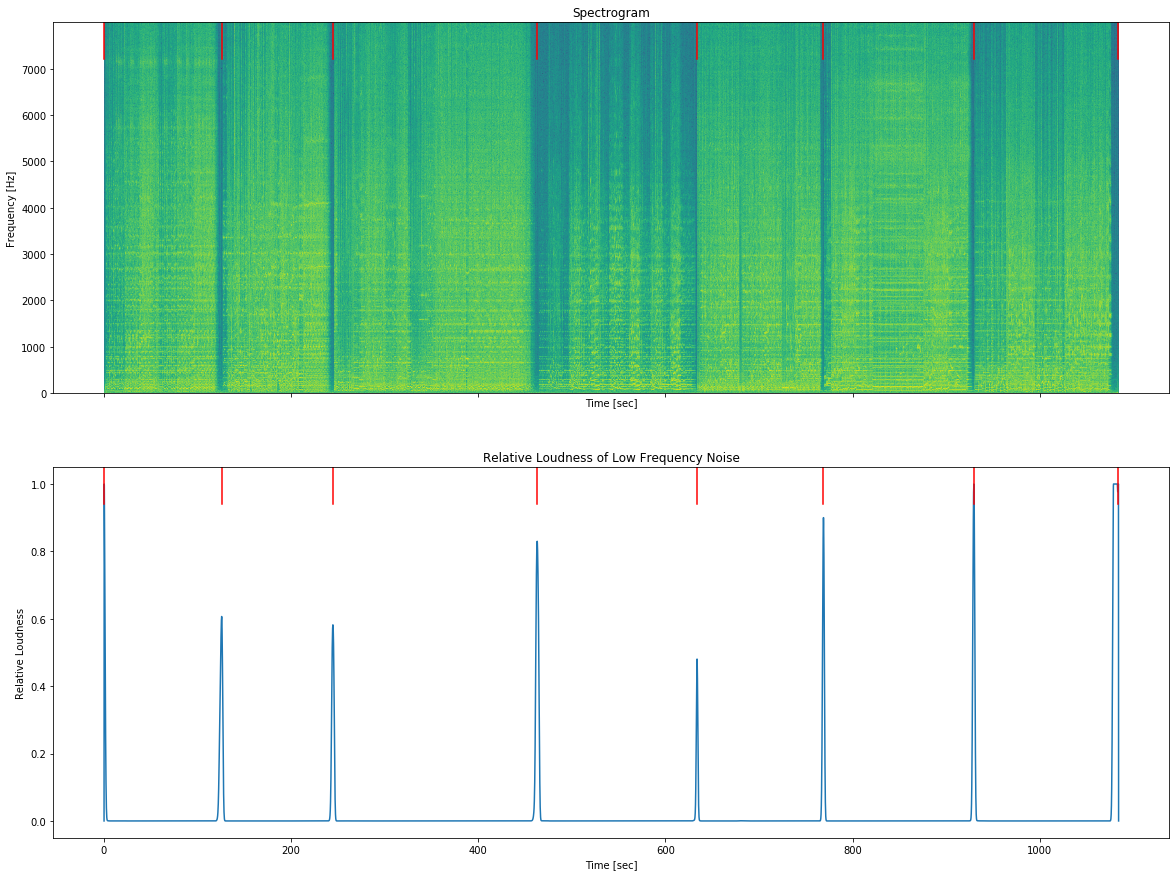

In [5]:
from matplotlib.colors import LogNorm
from scipy.signal import find_peaks
import datetime

fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, figsize=(20,15))

ax1.pcolormesh(time_ax, freq_ax[freq_ax <= 8000], spec[freq_ax<=8000,:], norm=LogNorm(), alpha=0.5)
ax1.set_ylabel('Frequency [Hz]')
ax1.set_xlabel('Time [sec]')
ax1.set_title("Spectrogram")

ax2.plot(time_ax, relative_loudness)
ax2.set_ylabel('Relative Loudness')
ax2.set_xlabel('Time [sec]')
ax2.set_title("Relative Loudness of Low Frequency Noise")

peaks, peaks_data = find_peaks(relative_loudness, distance=60/dt, width=0.5/dt, height=0.01, rel_height=0.5)    
for peak in peaks:
    ax1.axvline(peak*dt, color='r', ymin=0.9)
    ax2.axvline(peak*dt, color='r', ymin=0.9)

print("Tracks are separated at: " + str([(datetime.datetime(1970,1,1) + datetime.timedelta(seconds=peak)).strftime("%M:%S") for peak in peaks*dt]))
plt.show()  

#### Now we look specifically at the peaks themselves. 
We grab the region around the peaks of the loudness signal and look at where the "boundaries" of the peaks have been chosen by the peak finding algorithm, shown by the red dots. We configured it to take the boundary at one half the total height of the peak, to ensure that the region within would not have contamination from the end of one song or the beginning of another. We can see that the peaks were detected cleanly and that there is little to no noise in the loudness signal aroudn them. The first and last peak look slightly weird because the characteristics of the period before and after the record start playing are different than the inter-track regions.

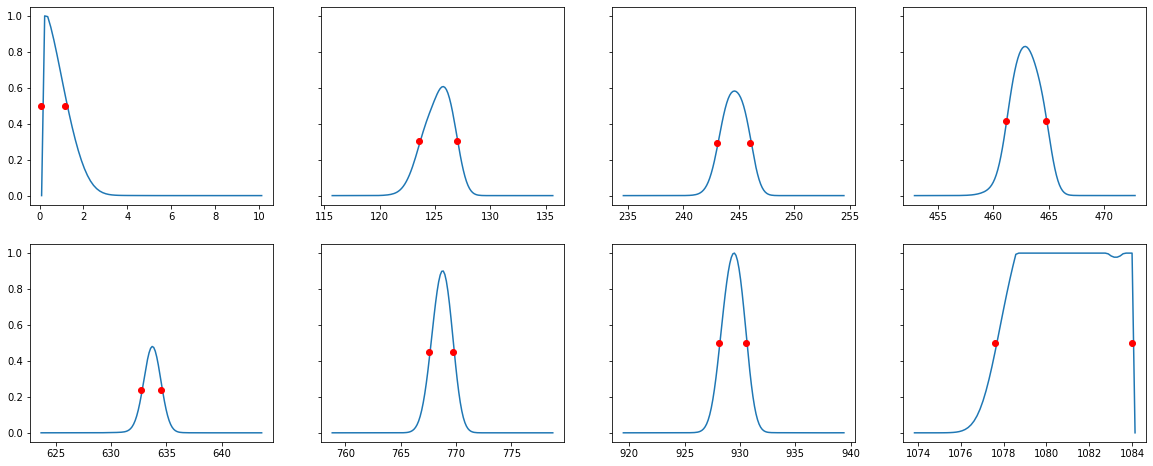

In [6]:
def get_mask(center, spread, axis):
    return (axis > (center - spread)) & (axis < (center + spread))

fig, axs = plt.subplots(2, 4, sharey=True)
for i in range(len(peaks)):
    peak_sample = peaks[i]
    ax = axs.flatten()[i]
    
    center = peak_sample * dt
    mask = get_mask(center, 10, time_ax)
    ax.plot(time_ax[mask], relative_loudness[mask])
    ax.plot(peaks_data["left_ips"][i] * dt, peaks_data["width_heights"][i], "ro")
    ax.plot(peaks_data["right_ips"][i] * dt, peaks_data["width_heights"][i], "ro")

To validate that we are actually isolating something meaningful, we write out the samples within those red regions to a new file, called `silence.wav`. This allows us to ensure that the algorithm is accurately detecting silent portions of the record.

In [7]:
silence = np.concatenate(
    [
        signal[int(left*dt*sample_rate):int(right*dt*sample_rate)] 
        for left, right in 
        zip(peaks_data["left_ips"], peaks_data["right_ips"])
    ]
).astype('int16')

wavfile.write("silence.wav", sample_rate, silence)

Now we look in to how to quantitavely measure the amount of noise. One way to do this is to calculate the signal to noise ratio, which is a quantity measured in decibels. [3] Decibels are a logarithmic quanitity representing signal strength, which is appropriate, because human perception of sound is logarithmic as well. [3]

To calculate the signal to noise ratio, we must calculate the loudness of the song as well as the loudness of the "silence". The loudness of the silence represents the amount of noise caused by crackle, background hiss, and rumble in the recording. To measure the signal in dB, we use a formula given in the IEC 61606-3 standard.
![image.png](images/IEC.png) [4]
First, we generate a refrence sinusoid at 997Hz with an amplitude of 32767, the maximum amplitude. Then we calculate the root mean squared amplitude to get our reference rms value. Then, we calculate the RMS amplitude of the entire recording as well as the RMS amplitude of the silent portions.

In [8]:
from math import pi
from math import sqrt
from math import log10

def rms(signal):
    return sqrt(np.average(np.power(signal, 2)))

ref_time = np.linspace(0,10, 44100*10)
ref = np.sin(997*2*pi*ref_time) * 32767
rms_ref = rms(ref)

db_ref = 20 * log10(rms_ref/rms_ref)
db_song = 20 * log10(rms(signal)/rms_ref)
db_silence = 20 * log10(rms(silence)/rms_ref)
snr = db_song - db_silence
print("Song volume: {:.2f} dB".format(db_song))
print("Noise volute: {:.2f} dB".format(db_silence))
print("Signal to Noise Ratio: {:.2f} dB".format(snr))

Song volume: -17.46 dB
Noise volute: -51.07 dB
Signal to Noise Ratio: 33.61 dB


A higher signal to noise ratio represents less noise in the overall signal. An increase of about 6 dB represents a signal containing half as much noise. Some results from running this algorithm on each record in our collection are included below, and they match up with our qualitative assesment of those records. Note that C_1 and C_2 are included but violate our assumptions about the structure of a record (multiple tracks per record with silent portions in between), so the values are not reasonable.

| Name | Signal To Noise (dB)    | Record Volume  (dB)   | Number of Tracks         | Track 1                    | Track 2                    | Track 3                    | Track 4                    | Track 5                    | Track 6                    | Track 7                    | Track 8                    | Track  9                   |
| ---- | ----------------------- | --------------------- | ------------------------ | -------------------------- | -------------------------- | -------------------------- | -------------------------- | -------------------------- | -------------------------- | -------------------------- | -------------------------- | -------------------------- |
| A_1  | 33.60                   | -17.45                | 8                        | 00:00                      | 02:05                      | 04:04                      | 07:42                      | 10:33                      | 12:48                      | 15:29                      | 18:03                      |                            |
| A_2  | 34.74                   | -16.49                | 8                        | 00:00                      | 02:20                      | 04:25                      | 06:52                      | 09:31                      | 12:05                      | 14:47                      | 17:08                      |                            |
| A_3  | 34.13                   | -17.02                | 8                        | 00:01                      | 02:31                      | 05:05                      | 08:23                      | 11:14                      | 13:38                      | 16:58                      | 20:10                      |                            |
| A_4  | 34.16                   | -16.97                | 9                        | 00:00                      | 02:14                      | 04:28                      | 07:59                      | 10:55                      | 13:11                      | 16:11                      | 19:52                      | 21:56                      |
| B_1  | 30.08                   | -21.43                | 8                        | 00:00                      | 05:07                      | 06:26                      | 09:12                      | 10:34                      | 14:21                      | 16:09                      | 19:24                      |                            |
| B_2  | 30.16                   | -21.76                | 9                        | 00:01                      | 03:33                      | 05:17                      | 06:52                      | 10:07                      | 11:20                      | 15:40                      | 20:01                      | 21:46                      |
| C_1  | 35.27                   | -16.40                | 4                        | 00:10                      | 02:59                      | 12:49                      | 18:24                      |                            |                            |                            |                            |                            |
| C_2  | 31.88                   | -20.86                | 5                        | 00:01                      | 01:15                      | 05:50                      | 10:03                      | 18:58                      |                            |                            |                            |                            |
| D    | 39.48                   | -15.76                | 6                        | 00:00                      | 03:35                      | 07:24                      | 10:46                      | 14:24                      | 18:44                      |                            |                            |                            |

We can see that we get consistent values for background noise across multiple sides of the same record, as well as multiple records which stands to reason. A cursory examination of the tracking times reveals that (save for C1 and C2) they are reasonable, and indicate that the prototype is functioning as it should.